# Projet numérique : ligne de niveau

Philomène Blot et Elise Costa

## Amorce

Condition raisonnable : comme f est supposée continûment différentiable, alors elle est continue.
Posons g : t -> f(0,t). Par construction, g est aussi continue sur [0,1].

D'après le TVI si f(0,0) = g(0) <= c et si f(0,1) = g(1) >= c ou vice-versa, il existe bien t appartenant à [0,1] tel que g(t) = f(0,t) = c

#### Fonction conforme au squelette

Plusieurs algorithmes existent pour trouver un tel t. Comme l'appel à la fonction qui permettra de l'obtenir est unique, on choisit d'implémenter une dichotomie par soucis de simplicité sur les hypothèses (la complexité de find_seed, ici, partie_entière(log2(eps)), est négligeable devant celle de la fonction contour_simple)

In [16]:
def find_seed(g, c=0, eps=2**(-26)) :
    fa, fb = g(0.0,0.0), g(0.0,1.0)
    
    # on teste si on se trouve dans le cas du TVI
    if (fa > c and fb > c) or (fa < c and fb < c) :
        raise ValueError("Dichotomie impossible")
    
    # on est dans le cas du TVI
    else :
        # on chercher qui de fa ou de fb est plus grand que c
        fpetit = min(fa, fb)
        fgrand = max(fa,fb)
        if fpetit == fa :
            petit, grand = 0, 1
        else :
            petit, grand = 1, 0
            
        m = (petit + grand)/2 
        fm = g(0,m)
        
        while (abs(fm - c) > eps) : 
            if fm >= c :
                grand, fgrand = m, fm
            else :
                petit, fpetit = m, fm
            m = (petit + grand)/2
            fm = g(0,m)
            
        return float(m)

#### test

In [17]:
def g(x,y) :
    return x+y+0.01
find_seed(g,0.5)

0.49000000953674316

La fonction dichotomie fonctionne bien.

## Propagation

On utilise la méthode de Newton généralisée appliquée à la fonction F :


$\begin{array}{ccccc}
F_{n+1}& : & \mathbb{R}^{2} & \to & \mathbb{R}^{2} \\
 & & \left( \begin{array}{c}
x \\
y \\
\end{array} \right) & \mapsto & \left( \begin{array}{c}
f(x,y)-c \\
(x-x_{n})^2 +(y-y_{n})^2 - \delta^2 \\
\end{array} \right) \\
\end{array}$

On cherche à tracer la ligne de niveau d'une fonction f qui respecte les conditions énoncées dans l'amorce. Pour cela, l'énoncé nous demande de renvoyer à partir de f, deux listes correspondant respectivement aux abscisses et ordonées des points de cette ligne. La distance entre deux points consécutifs ne doit pas excéder une valeur delta (= 0.01 par défaut) 

On a recours à un processus itératif.
On note x et y les listes contenant respectivement l'abscisse et l'ordonnée de chaque point trouvé.
Pour respecter la condition , on pose à chaque n + 1-ème étape la fonction : \begin{equation} F_{n+1} 
\end{equation} définie comme ci-dessus.

  
Avec  \begin{equation} V_{n} =  
 \left( \begin{array}{c}
v_{nx} \\
v_{ny} \\
\end{array} \right)
\end{equation}
 qui correspond au point proche que l'on a trouvé à partir du point  𝑋𝑛 (cf Rubrique point proche pour plus d'explications).
On applique ensuite à cette fonction la méthode de Newton non lisse.
D'après le cours, on sait que le  𝑋𝑛 de la ligne de niveau s'obtient par la formule suivante :
                       $X_{n+1}$ = $X_n - J_{n}^{-1}(X_n)F_{n}(X_n)$
Avec  𝐽−1𝑛 l'inverse de la jacobienne de  𝐹𝑛 bien définie grâce aux hypothèses formulées sur f.
On s'arrête lorsque l'on obtient un point qui sort du cadre de contour simple.

On installe autograd :

In [18]:
pip install autograd

Note: you may need to restart the kernel to use updated packages.


On charge les modules dont on aura besoin

In [19]:
from math import sqrt
import autograd
from autograd import numpy as np
import matplotlib.pyplot as plt

On code les fonctions auxiliaires :

1/ Fonctions pour obtenir le point proche

Pour trouver à la n+1 étape le point proche qui va nous servir de point de départ à notre méthode de newton, on effectue un calcul du gradient de notre fonction f au point  𝑋𝑛 trouvé à la n-ième étape.
Comme on sait que le gradient est orthogonal aux lignes de niveau, on obtient alors à partir du calcul (1), la direction selon laquelle on se déplace depuis notre point  𝑋𝑛.

On se déplace alors à gauche ou à droite du distance delta. On obtient par ce procédé le point proche  𝑉𝑛.

In [1]:
def norme(X):
    return sqrt(X[0][0]**2 + X[1][0]**2)

def gradient_f(f,a,b) :
    g = autograd.grad
    return np.r_[g(f,0)(float(a),float(b)), g(f,1)(float(a),float(b))]

# premier choix pour le vecteur tangeant
def pointProche_1(f,x,y, delta) :
    # calcul du gradient
    grad = gradient_f(f,float(x),float(y))
    # on obtient la direction voulue à partir des coordonnées calculées
    v = np.array([[-grad[1]],[grad[0]]])    
    n = norme(v)
    # on fait attention à ce que le gradient ne soit pas nul
    if n == 0 :
        raise ValueError("Division par 0 interdite")
    else :
        return np.array([[x],[y]]) + (v/n)*delta

# deuxième choix pour le vecteur tangent    
def pointProche_2(f,x,y, delta) :
    grad = gradient_f(f,float(x),float(y))
    v = np.array([[grad[1]],[-grad[0]]])  
    n = norme(v)
    if n == 0 :
        raise ValueError("Division par 0 interdite")
    else :
        return np.array([[x],[y]]) + (v/n)*delta  

2/ Fonctions pour obtenir le nouveau point de la liste

On se place toujours à la n+1 ième étape. Pour obtenir le point  𝑋𝑛+1 , on utilise la méthode de Newton explicitée plus haut. On calcule alors la jacobienne de la fonction  𝐹𝑛  grâce à autograd. Puis on l'évalue au point  𝑋𝑛.

In [2]:
def J_F(F,a,b) :
    # calcul de la jacobienne
    j = autograd.jacobian
    return np.c_[j(F,0)(float(a),float(b)), j(F,1)(float(a),float(b))]
    
def Newton(F, v, eps = 2**(-26), maxiter = 100) :
    for _ in range(maxiter) :
        # calcul de l'inverse de la jacobienne conformément à la formule
        J_inv = np.linalg.inv(J_F(F, v[0][0],v[1][0]))
        # on applique la formule
        X = v - np.dot(J_inv, F(v[0][0],v[1][0]).T)
        if (norme(X-v) < eps ) :
            return X
        else :
            v = X
    return(X)

In [4]:
def simple_contour( f, c=0.0, delta= 0.01):
    x, y = [], []
    # on cherche le premier point dans l'ensemble {0}*[0,1]
    try :
        yo = find_seed(f,c)
    except ValueError :
        return x,y
    # on initialise alors nos deux listes
    x.append(0)
    y.append(float(yo))
    
    #on a trouvé le premier point    
    bool_continuation = True
    
    #on implémente la fonction F définie plus haut
    def F(a,b) :
             return np.array([f(a,b)-c, (a-x[-1])**2 + (b-y[-1])**2 - delta**5])
    
    # on cherche à partir à droite du côté gauche pour être dans le carré et on suivra toujours ce sens pour la création de la ligne de niveau
    premier_grad = gradient_f(f,x[-1],y[-1])
    if premier_grad[1] >= 0 :
        pointProche = lambda f,x,y,delta : pointProche_2(f,x,y,delta)
    else :
        pointProche = lambda f,x,y,delta : pointProche_1(f,x,y,delta)
    
    
    while bool_continuation :
        
        # on cherche un premier point proche
        try :
            v = pointProche(f,x[-1],y[-1], delta)
        except ValueError:
            return x,y
        X = Newton(F,v)
        # (a,b) vérifie les conditions voulues pour faire partie de la ligne de niveau i.e. est dans le carré
        a,b = X[0,0],X[1,0]
        if a>=0 and a<=1 and b>=0 and b<=1 :
            x.append(a)
            y.append(b)
        else :
            bool_continuation = False
    
    return x,y

Test

In [23]:
def f(x,y) : 
    return(x**2+y**2 - 0.5)

In [24]:
x,y = simple_contour(f, c=0.3)

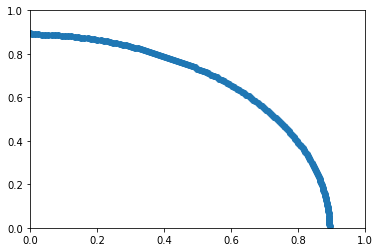

In [25]:
plt.scatter(x,y)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

##  Contour complexe

In [5]:
# Rotators
# ------------------------------------------------------------------------------
LEFT, UP, RIGHT, DOWN = 0, 1, 2, 3  # clockwise

In [6]:
def rotate_direction(direction, n=1):
    return (direction + n) % 4


def rotate(x, y, n=1):
    if n == 0:
        return x, y
    elif n >= 1:
        return rotate(1 - y, x, n - 1)
    else:
        assert n < 0
        return rotate(x, y, n=-3 * n)


def rotate_function(f, n=1):
    def rotated_function(x, y):
        xr, yr = rotate(x, y, -n)
        return f(xr, yr)

    return rotated_function

In [7]:
# Complex Contouring
# ------------------------------------------------------------------------------

# Customize the simple_contour function used in contour :
# simple_contour = smart_simple_contour


def contour(f, c, xs=[0.0, 1.0], ys=[0.0, 1.0], delta=0.01):
    curves = []
    nx, ny = len(xs), len(ys)
    for i in range(nx - 1):
        for j in range(ny - 1):
            xmin, xmax = xs[i], xs[i + 1]
            ymin, ymax = ys[j], ys[j + 1]

            def f_cell(x, y):
                return f(xmin + (xmax - xmin) * x, ymin + (ymax - ymin) * y)

            done = set()
            for n in [0, 1, 2, 3]:
                if n not in done:
                    rotated_f_cell = rotate_function(f_cell, n)
                    x_curve_r, y_curve_r = simple_contour(rotated_f_cell, c, delta)
                    exit = None
                    if len(x_curve_r) >= 1:
                        xf, yf = x_curve_r[-1], y_curve_r[-1]
                        if xf == 0.0:
                            exit = LEFT
                        elif xf == 1.0:
                            exit = RIGHT
                        elif yf == 0.0:
                            exit = DOWN
                        elif yf == 1.0:
                            exit = UP
                    if exit is not None:  # a fully successful contour fragment
                        exit = rotate_direction(exit, n)
                        done.add(exit)

                    x_curve, y_curve = [], []
                    for x_r, y_r in zip(x_curve_r, y_curve_r):
                        x, y = rotate(x_r, y_r, n=-n)
                        x_curve.append(x)
                        y_curve.append(y)
                    x_curve = np.array(x_curve)
                    y_curve = np.array(y_curve)
                    curves.append(
                        (xmin + (xmax - xmin) * x_curve, ymin + (ymax - ymin) * y_curve)
                    )
    return curves